In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

## Implementation of Logistic Regression Baseline (OvR)

### Data Preparation:

In [2]:
# read in business data
nolaBus = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/nolaRestaurants.csv')

In [3]:
# filter to columns of interest
nolaBus = nolaBus[['business_id', 'postal_code', 'latitude', 'longitude', 
             'stars', 'review_count', 'is_open', 'categories']]

In [4]:
# rename columns
nolaBus = nolaBus.rename(columns = {'stars':'businessRating', 'review_count': 'businessReviewCount'})

In [5]:
# read in reviews data
nolaReviews = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/yelp_review.csv')

In [6]:
# filter to columns of interest
nolaReviews2 = nolaReviews[['review_id', 'user_id', 'business_id', 'stars']]

In [7]:
# rename columns
nolaReviews2 = nolaReviews2.rename({'stars': 'userRating'}, axis = 1)

In [8]:
# merge reviews and business data
nola = pd.merge(left = nolaBus, right = nolaReviews2, how = 'inner', on = 'business_id')

In [9]:
# get list of users with greater than 100 reviews
usersGreater99Reviews = nola['user_id'].value_counts()[nola['user_id'].value_counts()>=100].index.tolist()

# filter out users with less than 100 reviews
nola2 = nola[nola.user_id.isin(usersGreater99Reviews)]

# drop instances where users reviewed the same restaurant twice
nola2 = nola2.drop_duplicates(['user_id', 'business_id', 'userRating'], keep = 'first')

# One-hot encode categorical variables
categories = nola2['categories'].str.get_dummies(sep = ', ')
postal_codes = nola2['postal_code'].astype('str').str.get_dummies(sep = ', ')

# Create new dataframe with encoded variables
nola3 = pd.merge(categories, postal_codes, how = 'inner', left_index = True, right_index = True)
nola3 = pd.merge(nola2, nola3, how = 'inner', left_index = True, right_index = True)

# get average user rating and number of reviews for each user
nola4 = pd.merge(nola3, 
                 nola3.groupby('user_id', as_index = False).agg({'review_id':'nunique', 'userRating':'mean'}) \
                      .rename({'review_id':'countUserReviews', 'userRating':'avgUserRating'}, axis = 1),
                 how = 'left', on = 'user_id')

nola4 = nola4.drop(['business_id', 'review_id', 'user_id', 'categories', 'postal_code', 'nan'], axis = 1)

In [10]:
nola4.head()

,latitude,longitude,businessRating,businessReviewCount,is_open,userRating,Acai Bowls,Active Life,Adult Entertainment,African,...,70129.0,70130.0,70131.0,70139.0,70140.0,70163.0,70170.0,70195.0,countUserReviews,avgUserRating
0,29.950647,-90.074427,4.5,350,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,592,3.021959
1,29.950647,-90.074427,4.5,350,1,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,4.663462
2,29.950647,-90.074427,4.5,350,1,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,618,4.108414
3,29.950647,-90.074427,4.5,350,1,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,187,3.732620
4,29.950647,-90.074427,4.5,350,1,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,162,3.833333


### Model Implementation:

- To start I will implement logistic regression as my baseline algorithm. Because there are many categories that are likely not useful, I will incliude a regularization parameter to shrink these categories:

In [11]:
# Create X and y sets
X = nola4.drop('userRating', axis = 1)
y = nola4['userRating']

# Split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# Identify numerical columns
numericCols = [col for col in X.columns.tolist() if col in ['latitude', 'longitude', 'businessRating', 
                                                            'businessReviewCount', 'countUserReviews',
                                                            'avgUserRating']]

# Prepare preprocessing for pipeline
numeric_transformer = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numeric_transformer, numericCols))

# Prepare pipeline
pipe_logreg = Pipeline(steps = [('preprocessor', preprocessor),
                                ('LogisticRegression', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', 
                                                                          max_iter = 1000, C = 0.01))])

# Prepare GridSearch
gs = GridSearchCV(estimator = pipe_logreg,
                  param_grid = {'LogisticRegression__C': np.logspace(-2, 4, 20)},
                  scoring = 'accuracy',
                  cv = 2)

# Compute cross-validation score using RMSE
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, scoring = 'r2', cv = 5)
print('CV R2: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV Accuracy: 0.470 +/- 0.007
CV R2: 0.130 +/- 0.017


In [12]:
# Use k-fold cross validation to construct a model and output classification report
gs.fit(X_train, y_train)
logreg_model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 0.05,
                                  #C = gs.best_params_['LogisticRegression__C'],
                                  max_iter = 5000)

scores = cross_val_score(logreg_model, X_train, y_train, cv = 5)
print('Logistic Regression CV scores:', scores)

logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)

# Print classification report for test and validation sets
print('Classification report for Logistic Regression model on Test Data:')
print(classification_report(y_test, y_pred, zero_division = 0))

Logistic Regression CV scores: [0.4629377  0.47885402 0.45702592 0.47816197 0.45313922]
Classification report for Logistic Regression model on Test Data:
              precision    recall  f1-score   support

         1.0       1.00      0.02      0.04       139
         2.0       0.40      0.02      0.03       384
         3.0       0.40      0.28      0.33      1026
         4.0       0.46      0.76      0.57      1904
         5.0       0.55      0.36      0.44      1259

    accuracy                           0.47      4712
   macro avg       0.56      0.29      0.28      4712
weighted avg       0.48      0.47      0.42      4712



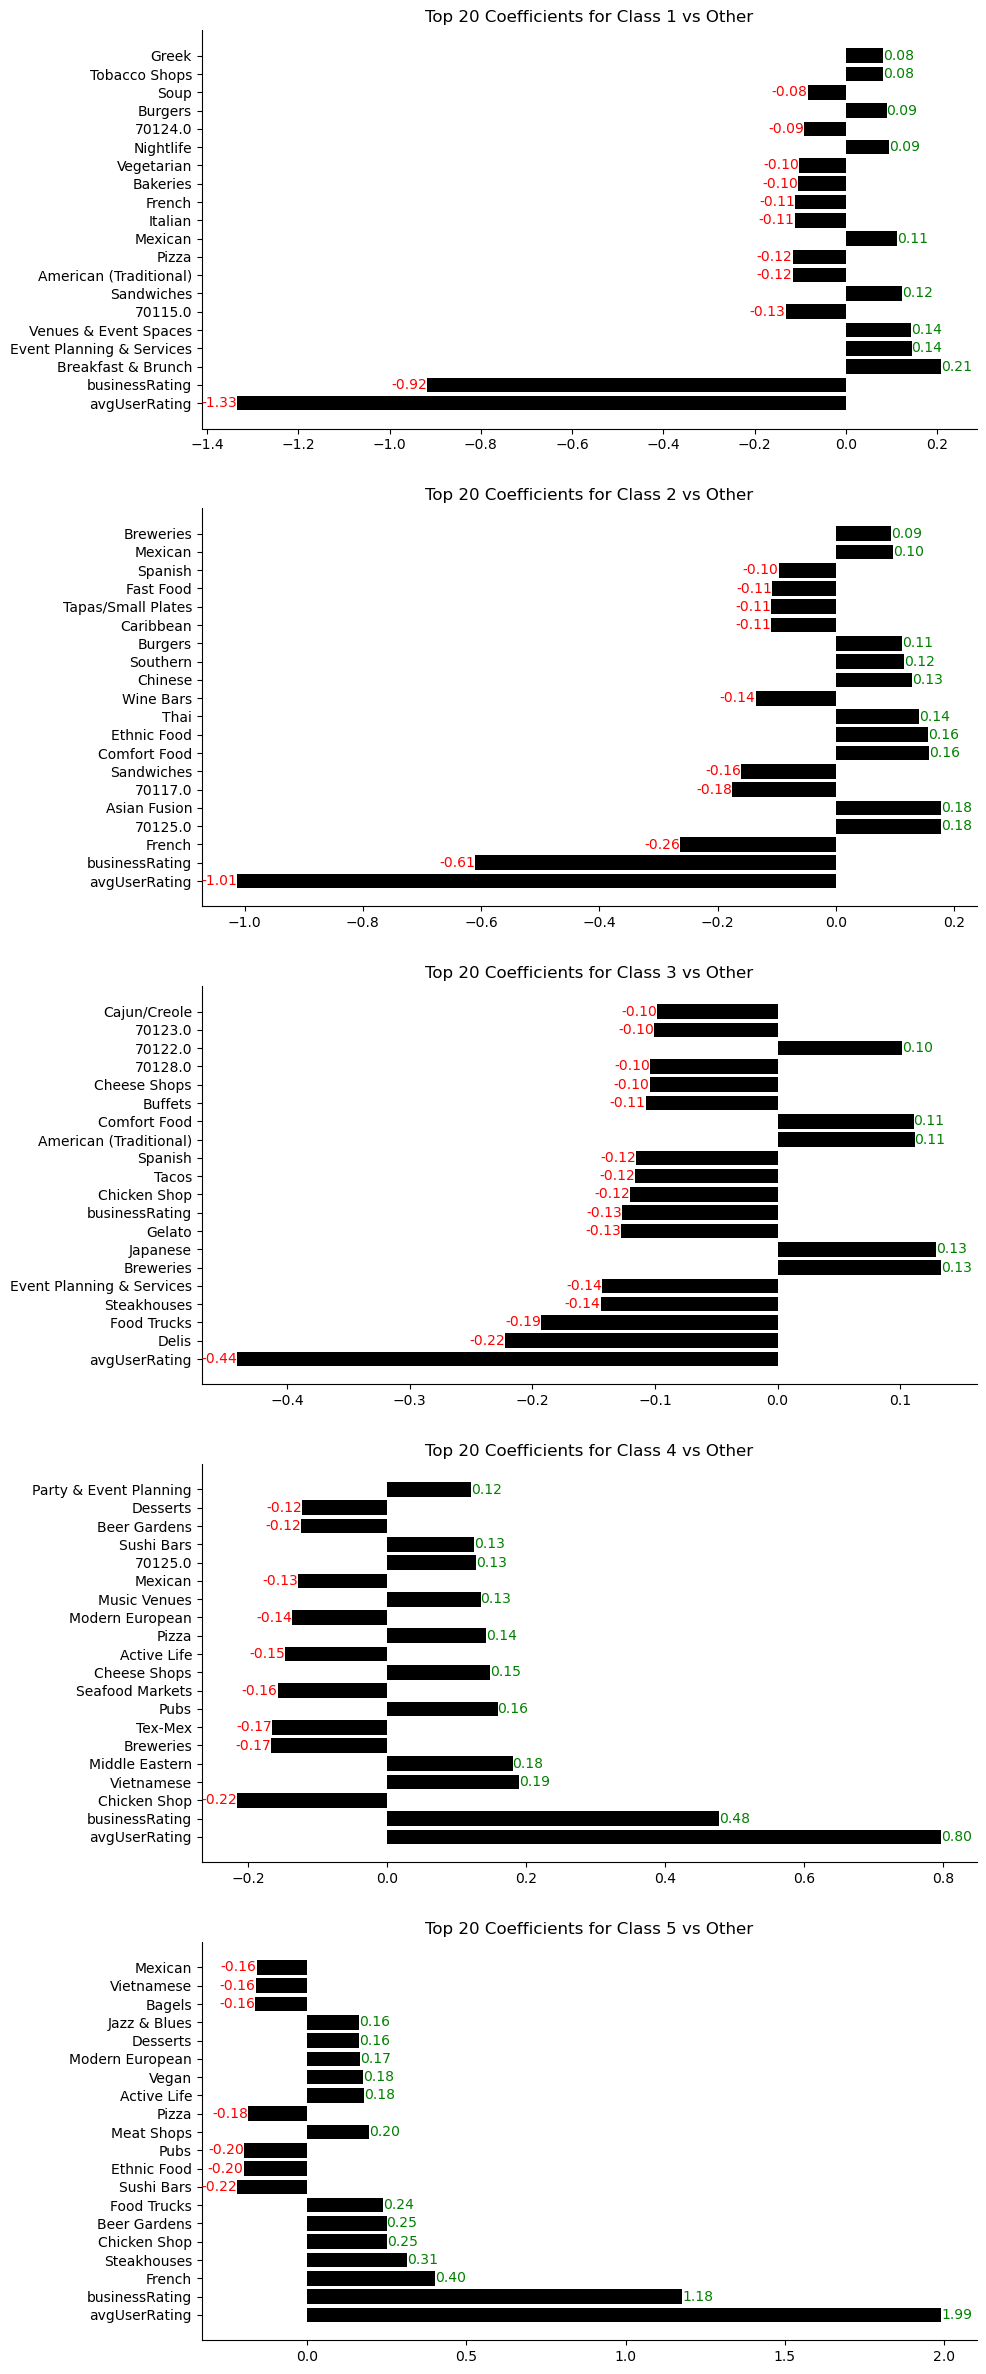

<Figure size 600x2000 with 0 Axes>

<Figure size 600x2000 with 0 Axes>

<Figure size 600x2000 with 0 Axes>

<Figure size 600x2000 with 0 Axes>

<Figure size 600x2000 with 0 Axes>

In [13]:
# Visualize Top 20 Coefficients
n_coefs = 20
fig, axs = plt.subplots(5, 1, figsize=(10, 30))

for i in range(5):
    coefs = logreg_model.coef_[i]
    top_coefs_idx = abs(coefs).argsort()[::-1][:n_coefs]
    top_coefs = coefs[top_coefs_idx]
    top_names = X_train.columns[top_coefs_idx]

    axs[i].barh(range(n_coefs), top_coefs, color = 'black')
    axs[i].set_yticks(range(n_coefs))
    axs[i].set_yticklabels(top_names, fontsize = 10)
    axs[i].set_title('Top 20 Coefficients for Class {} vs Other'.format(i+1), fontsize=12)
    
    for j, coef in enumerate(top_coefs):
        if coef > 0:
            axs[i].text(coef, j, '{:.2f}'.format(coef), ha = 'left', va = 'center', fontsize = 10, color = 'green')
        else:
            axs[i].text(coef, j, '{:.2f}'.format(coef), ha = 'right', va = 'center', fontsize = 10, color = 'red')


    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    
    plt.figure(figsize = (6, 20)) 
    plt.subplots_adjust(hspace = 1)
    
plt.show()

## Takeaways:

- For the most part, this isn't particularly surprising given what we already found during the exploratory analysis. For starters, the top most important variable in predicting how a user will rate a restaurant is the business average rating and the user's average rating. For the most part, the higher the average rating for a business is, the more likely an individual user will be to rate it highly. Additionally, for the most part, the higher the average user rating is, the more likely they'll be to rate a restaurant positively.
- Another takeaway is the effect of location on star rating. Across the different classes, zip code and longitude/latitude come up fairly consistently in the top 20 categories, as either being positively or negatively related to a given star rating. Whether this is is because different neighborhoods actually have better restaurants -- for example high-end areas might have nicer restuarants, or restuarant density, for example we've seen that the more reviews a restaurant has, the better it's star rating tends to be, is unknown

## Lasso Regression

- Testing the above with Lasso Regression so we have something to compare our recommender to:

In [14]:
# Create X and y sets
X = nola4.drop('userRating', axis = 1)
y = nola4['userRating']

In [15]:
# Split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [16]:
# Identify numerical columns
numericCols = [col for col in X.columns.tolist() if col in ['latitude', 'longitude', 'businessRating', 
                                                            'businessReviewCount', 'countUserReviews',
                                                            'avgUserRating']]

# Prepare preprocessing for pipeline
numeric_transformer = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numeric_transformer, numericCols))

# Prepare pipeline
pipe_lasso = Pipeline(steps = [('preprocessor', preprocessor),
                               ('Lasso', Lasso(alpha = 0.01))])

# Prepare GridSearch
gs = GridSearchCV(estimator = pipe_lasso,
                  param_grid = {'Lasso__alpha': np.logspace(-4, 0.5)},
                  scoring = 'neg_root_mean_squared_error',
                  cv = 2)

In [22]:
# gs.get_params

In [24]:
# Compute cross-validation score using RMSE
scores = cross_val_score(gs, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5)
print('CV RMSE: %.3f +/- %.3f' % (np.mean(scores*-1), np.std(scores*-1)))

CV RMSE: 0.876 +/- 0.008


In [33]:
# Compute cross-validation score using R2
r2_scores_val = cross_val_score(gs, X_train, y_train, scoring = 'r2', cv = 5)
print('CV R2: %.3f +/- %.3f' % (np.mean(r2_scores), np.std(r2_scores)))

CV R2: 0.250 +/- 0.009


In [34]:
# Compute cross-validation score using R2
mae_scores_val = cross_val_score(gs, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 5)
print('CV MAE: %.3f +/- %.3f' % (np.mean(mae_scores*-1), np.std(mae_scores*-1)))

CV MAE: 0.679 +/- 0.008


In [28]:
# Use k-fold cross validation to construct our Lasso model using the optimal parameters identified in GridSearchCV
gs.fit(X_train, y_train)
lasso_model = Lasso(alpha = gs.best_params_['Lasso__alpha'], max_iter = 1000)

# Compute cross-validation score using RMSE
rmse_cv = cross_val_score(lasso_model, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5)
print('CV RMSE: %.3f +/- %.3f' % (np.mean(rmse_cv*-1), np.std(rmse_cv*-1)))

# Compute cross-validation score using RMSE
mae_cv = cross_val_score(lasso_model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 5)
print('CV MAE: %.3f +/- %.3f' % (np.mean(mae_cv*-1), np.std(mae_cv*-1)))

# Compute cross-validation score using R2
r2_scores = cross_val_score(lasso_model, X_train, y_train, scoring = 'r2', cv = 5)
print('CV R2: %.3f +/- %.3f' % (np.mean(r2_scores), np.std(r2_scores)))

CV RMSE: 0.881 +/- 0.006
CV MAE: 0.684 +/- 0.006
CV R2: 0.250 +/- 0.009


In [30]:
# Fit model and predict on test set
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

# Print R2 and RMSE for test set
print('RMSE Test Set: %.3f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE Test Set: %.3f' % mean_absolute_error(y_test, y_pred))
print('R2 Test Set: %.3f' % r2_score(y_test, y_pred))

RMSE Test Set: 0.884
MAE Test Set: 0.689
R2 Test Set: 0.245


In [78]:
# save test and validation scores to csv
test_scores = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/machine-learning-dse-i210-final-project-yelprestaurantrecommender/notebooks/model_scores.csv')
test_scores.loc[2] = ['Lasso Model', mean_absolute_error(y_test, y_pred), mae_cv.mean(), np.sqrt(mean_squared_error(y_test, y_pred)), rmse_cv.mean()]
test_scores.to_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/machine-learning-dse-i210-final-project-yelprestaurantrecommender/notebooks/model_scores.csv')

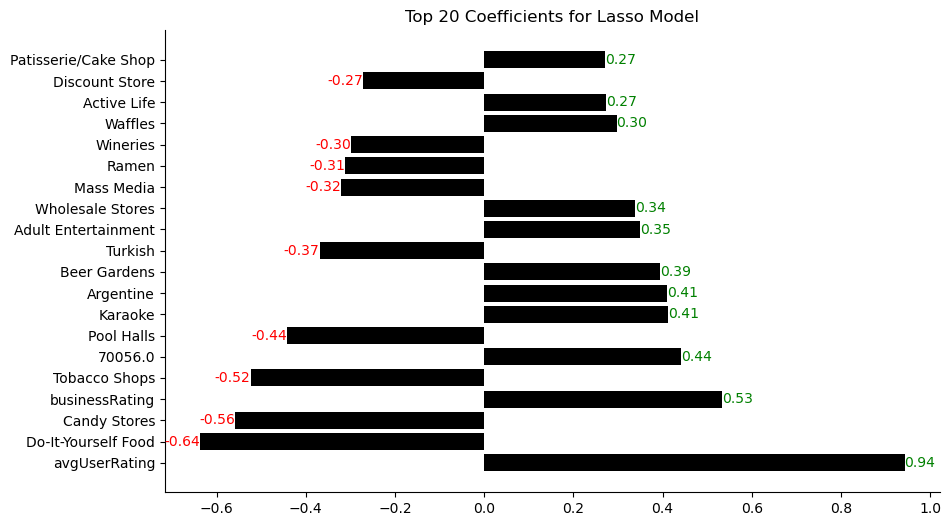

In [21]:
# Visualize top 20 coefficients
n_coefs = 20
coefs = lasso_model.coef_
top_coefs_idx = abs(coefs).argsort()[::-1][:n_coefs]
top_coefs = coefs[top_coefs_idx]
top_names = X_train.columns[top_coefs_idx]

plt.figure(figsize = (10, 6))
plt.barh(range(n_coefs), top_coefs, color = 'black')
plt.yticks(range(n_coefs), top_names, fontsize = 10)
plt.title('Top 20 Coefficients for Lasso Model', fontsize = 12)

for j, coef in enumerate(top_coefs):
    if coef > 0:
        plt.text(coef, j, '{:.2f}'.format(coef), ha = 'left', va = 'center', fontsize = 10, color = 'green')
    else:
        plt.text(coef, j, '{:.2f}'.format(coef), ha = 'right', va = 'center', fontsize = 10, color = 'red')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

Next I want to see a list of the coefficients that our Lasso model shrunk to zero:

In [22]:
# Find the indices of coefficients that are zero
zero_indices = np.where(lasso_model.coef_ == 0)[0]

# Get the names of the features with zero coefficients
zero_coefficient_features = X_train.columns[zero_indices]

# Print the features with zero coefficients
zero_coefficient_features_count = []
for feature in zero_coefficient_features:
    zero_coefficient_features_count.append((feature, X[feature].sum()))
    
sorted(zero_coefficient_features_count, key = lambda x: x[1], reverse = True)

[('latitude', 470388.397310472),
 ('Restaurants', 15701),
 ('Beer', 664),
 ('Wine & Spirits', 664),
 ('Caterers', 497),
 ('Juice Bars & Smoothies', 314),
 ('Soul Food', 305),
 ('Shopping', 216),
 ('Food Delivery Services', 184),
 ('Ice Cream & Frozen Yogurt', 182),
 ('Hotels', 161),
 ('Food Stands', 114),
 ('Whiskey Bars', 86),
 ('Gelato', 81),
 ('Poke', 51),
 ('70129.0', 43),
 ('Art Galleries', 42),
 ('International Grocery', 38),
 ('Dance Clubs', 37),
 ('Dim Sum', 37),
 ('Festivals', 36),
 ('Arcades', 34),
 ('70131.0', 32),
 ('Korean', 31),
 ('Taiwanese', 31),
 ('Country Clubs', 27),
 ('Laotian', 26),
 ('Musicians', 24),
 ('Fruits & Veggies', 23),
 ('70128.0', 22),
 ('Local Services', 21),
 ('Education', 20),
 ('Home Services', 20),
 ('Specialty Schools', 20),
 ('Home & Garden', 17),
 ('Pan Asian', 17),
 ('Photographers', 17),
 ('70170.0', 17),
 ('African', 15),
 ('Auction Houses', 15),
 ('Empanadas', 15),
 ('Fitness & Instruction', 14),
 ('Irish Pub', 14),
 ('Health Markets', 12),
 

In [23]:
len(zero_coefficient_features)

113

In [24]:
len(lasso_model.coef_)

321

## Clustering on Restaurant Features

Next I'm interested in seeing if I can cluster on different restaurant attributes to determine similarities between restaurants. The eventual goal is seeing if clustering helps us to improve model performance by predicting within different clusters, rather than within the entire dataset.

In [25]:
nolaBus2 = nolaBus.copy()

In [26]:
# create empty set to store categories in
categories = set()

# iterate through each category in the categories column and add it to the categories set
for i, val in enumerate(nolaBus2['categories']):
    for category in val.split(', '):
        categories.add(category)
        
# create empty dictionary to store categories and whether or not each row value is tagged as that category in
catDict = {}

# add each category in the categories set to the catDict
for category in categories:
    catDict[category] = []
    
# loop through each category in the categories column of the nola dataframe
# add 1 to catDict for each category in that column. if the category is not there, add 0
for i, val in enumerate(nolaBus2['categories'], 1):
    for category in val.split(', '):
        if category in catDict.keys():
            catDict[category].append(1)
    for key in catDict:
        if len(catDict[key]) < i:
            catDict[key].append(0)
        else:
            pass
        
# create dataframe from catDict and join it to the nola dataset
nolaBus2.reset_index(inplace = True, drop = True)
nolaBus2 = pd.concat([nolaBus2, pd.DataFrame.from_dict(catDict)], axis = 1)
nolaBus2.drop('categories', axis = 1, inplace = True)

In [27]:
nolaBus2['postal_code'] = nolaBus2['postal_code'].astype('object')

In [28]:
nolaBus2.head()

,business_id,postal_code,latitude,longitude,businessRating,businessReviewCount,is_open,Event Planning & Services,Chicken Shop,Tobacco Shops,...,Desserts,Food Court,Home Decor,Bars,Shaved Snow,Ramen,Flowers & Gifts,Breweries,Sandwiches,Street Vendors
0,YNjyv0gfOr2g8lbmUpTnKg,70112.0,29.950647,-90.074427,4.5,350,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,TLZ3-eDPLhUzfsWO4ad6Ug,70112.0,29.955415,-90.070062,4.0,382,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FRYkg_JvsWU9xIXZsEZcVA,70115.0,29.933388,-90.079498,3.5,27,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4IcB3QyMEA85UTWFKh9O9A,70119.0,29.976762,-90.086423,4.5,8,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Edg22x3CZkIv0GUib2oEFA,70118.0,29.948624,-90.131250,3.5,149,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [29]:
nolaBus3 = pd.get_dummies(nolaBus2[[col for col in nolaBus2.columns.tolist() if col != 'business_id']])

/Users/analeegraig/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [30]:
# Select numerical columns to be standardized
numerical_cols = ['businessRating', 'businessReviewCount', 'longitude', 'latitude']

# Standardize numerical columns
scaler = StandardScaler()
nolaBus3[numerical_cols] = scaler.fit_transform(nolaBus3[numerical_cols])

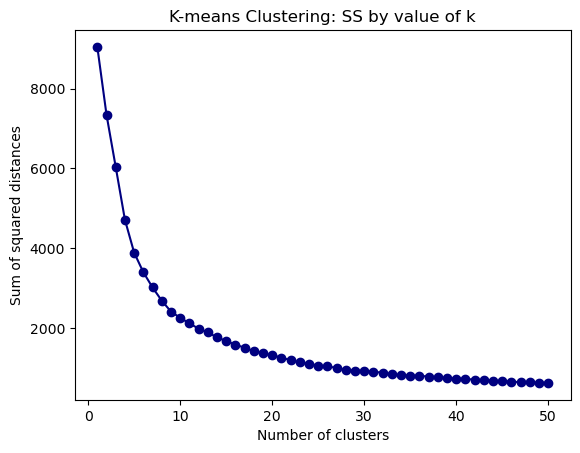

In [128]:
# Calculate sum of squared distances for different number of clusters
sse = []
for num_clusters in range(1, 51):
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42, n_init = 10)
    kmeans.fit(nolaBus3[numerical_cols])
    sse.append(kmeans.inertia_)

# Plot sum of squared distances for each number of clusters
plt.plot(range(1, 51), sse, marker = 'o', color = 'navy')
plt.title('K-means Clustering: SS by value of k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

In [32]:
# Find the optimal number of clusters using the elbow method
sse = np.array(sse)
elbow_index = np.argmin(np.gradient(np.gradient(sse))) + 1
optimal_num_clusters = elbow_index if elbow_index > 1 else 2

In [33]:
#optimal_num_clusters

In [34]:
# Apply k-means clustering
kmeans = KMeans(n_clusters = optimal_num_clusters, random_state = 42, n_init = 10)
nolaBus3['cluster'] = kmeans.fit_predict(nolaBus3[numerical_cols])

In [35]:
# Look at values per cluster
nolaBus3['cluster'].value_counts()

15    196
23    172
21    159
7     150
30    135
26    133
16    133
0     116
25    115
28    104
2      88
24     74
22     70
9      63
27     59
8      56
5      48
20     48
14     40
1      38
18     38
12     37
11     29
3      29
29     26
10     26
4      25
17     23
19     20
13     10
6       2
Name: cluster, dtype: int64

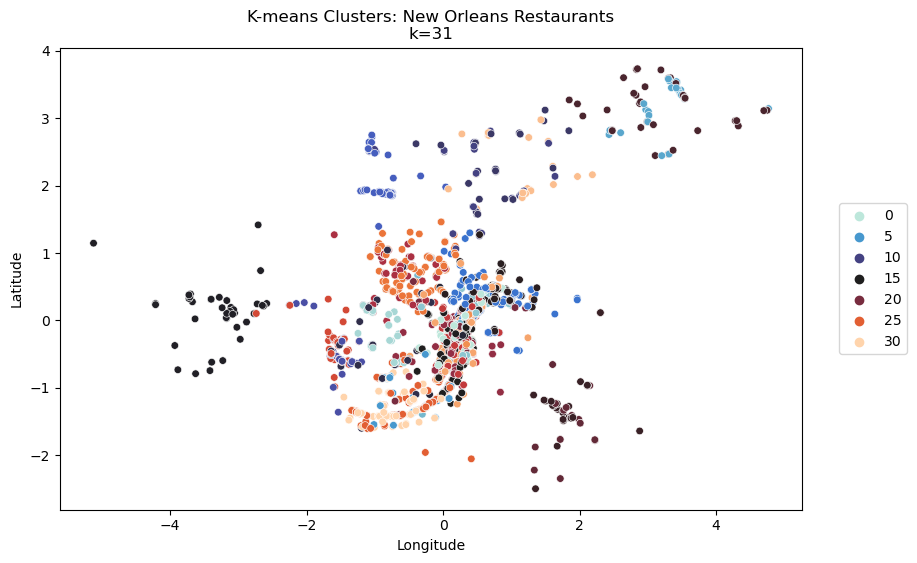

In [64]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(data = nolaBus3, y = 'latitude', x = 'longitude', hue = 'cluster', s = 30, palette = 'icefire')
ax.legend(bbox_to_anchor = (1.05, 0.5), loc = 'center left', borderaxespad = 0)
plt.subplots_adjust(right = 0.8)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('K-means Clusters: New Orleans Restaurants\nk=31')
plt.show()

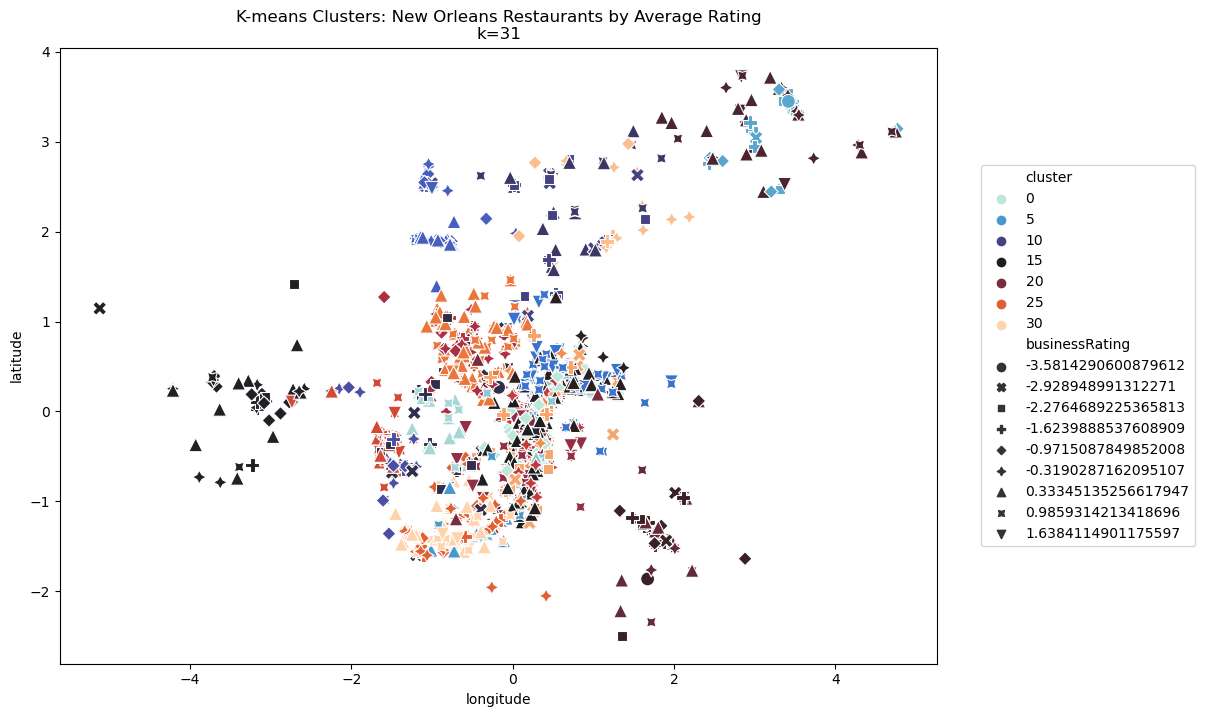

In [62]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(data = nolaBus3, y = 'latitude', x = 'longitude', 
                hue = 'cluster', s = 100, palette = 'icefire', style = 'businessRating')
ax.legend(bbox_to_anchor = (1.05, 0.5), loc = 'center left', borderaxespad = 0)
plt.subplots_adjust(right = 0.8)
plt.title('K-means Clusters: New Orleans Restaurants by Average Rating\nk=31')
plt.show()

Text(0, 0.5, 'Average Rating')

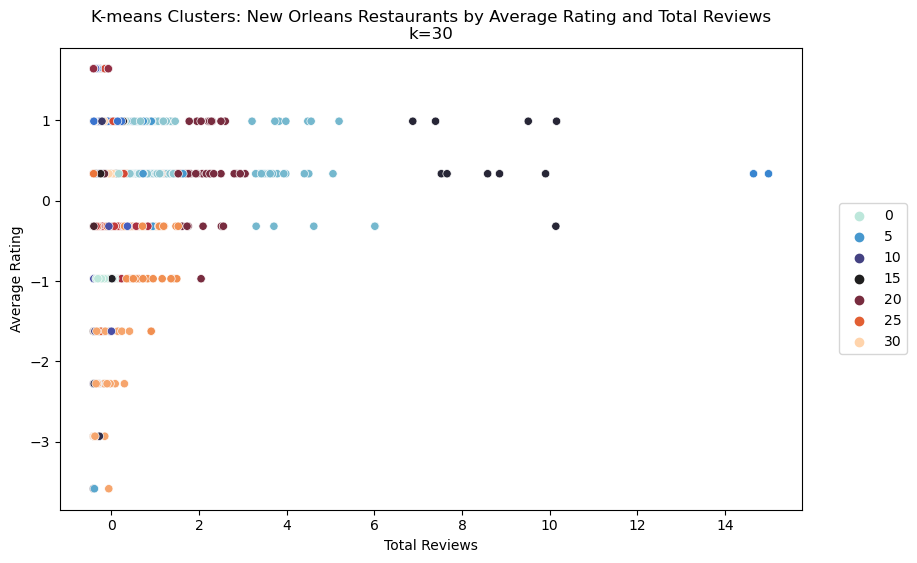

In [70]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(data = nolaBus3, x = 'businessReviewCount', y = 'businessRating', hue = 'cluster', palette = 'icefire')
ax.legend(bbox_to_anchor = (1.05, 0.5), loc = 'center left', borderaxespad = 0)
plt.subplots_adjust(right = 0.8)
plt.title('K-means Clusters: New Orleans Restaurants by Average Rating and Total Reviews\nk=30')
plt.xlabel('Total Reviews')
plt.ylabel('Average Rating')

In [39]:
nolaBus3['cluster'].value_counts()

15    196
23    172
21    159
7     150
30    135
26    133
16    133
0     116
25    115
28    104
2      88
24     74
22     70
9      63
27     59
8      56
5      48
20     48
14     40
1      38
18     38
12     37
11     29
3      29
29     26
10     26
4      25
17     23
19     20
13     10
6       2
Name: cluster, dtype: int64

## Takeaways:

1. I don't have too many interesting takeaways based on the above. There's some clear separation of the data based on geography, which shoudn't be surprising as this was one of the main variables feeding the clustering algorithm. It looks like this is the primary differentiator on which the classifier is built, which again I believe makes sense because there's not a ton of differentiation in terms of ratings, while there is much more differentiation in terms of longitude/latitude, just by the nature of how these different units are measured. Outside of that, there also does appear to be clustering based on businessReviewCount and businessRating, which again, shouldn't be shocking.

In [40]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer

In [41]:
# Fit the DBSCAN model
dbscan = DBSCAN(eps = 0.6, min_samples = 5, metric = 'euclidean')
dbscan.fit(nolaBus3[numerical_cols])

# Get the cluster labels
labels = dbscan.labels_

# Print the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters:', n_clusters)
print('Estimated number of noise points:', n_noise)

Estimated number of clusters: 29
Estimated number of noise points: 143


In [42]:
nolaBus3['dbscan_cluster'] = labels

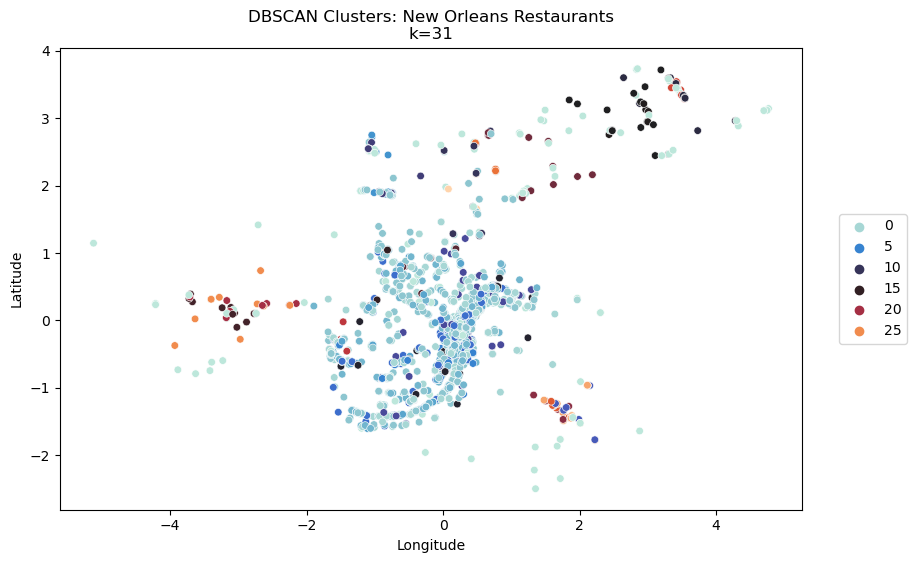

In [74]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(data = nolaBus3, y = 'latitude', x = 'longitude', hue = 'dbscan_cluster', s = 30, palette = 'icefire')
ax.legend(bbox_to_anchor = (1.05, 0.5), loc = 'center left', borderaxespad = 0)
plt.subplots_adjust(right = 0.8)
plt.title('DBSCAN Clusters: New Orleans Restaurants\nk=31')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

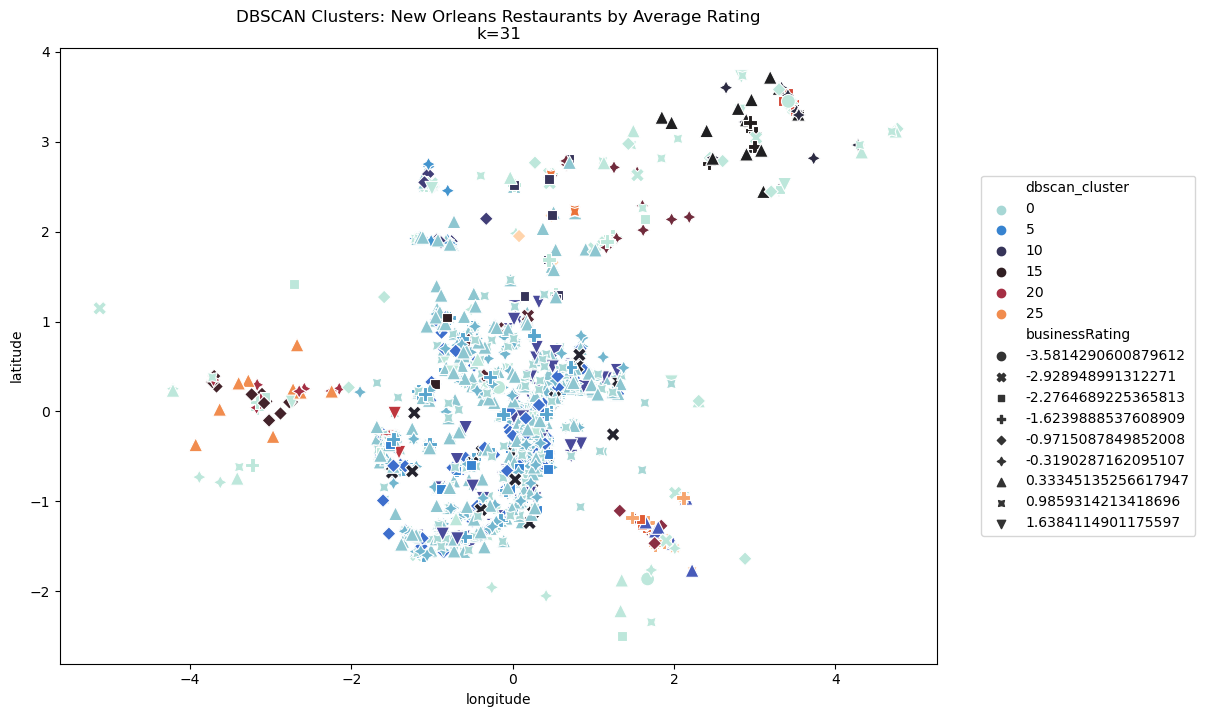

In [73]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(data = nolaBus3, y = 'latitude', x = 'longitude', 
                hue = 'dbscan_cluster', s = 100, palette = 'icefire', style = 'businessRating')
ax.legend(bbox_to_anchor = (1.05, 0.5), loc = 'center left', borderaxespad = 0)
plt.subplots_adjust(right = 0.8)
plt.title('DBSCAN Clusters: New Orleans Restaurants by Average Rating\nk=31')
plt.show()

Text(0.5, 1.0, 'DBSCAN Clusters: New Orleans Restaurants by Average Rating and Total Reviews\nk=30')

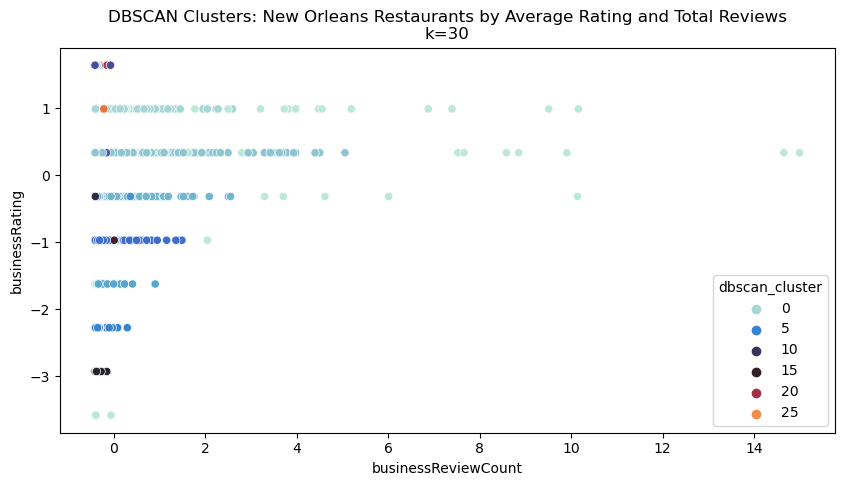

In [45]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = nolaBus3, x = 'businessReviewCount', y = 'businessRating', 
                hue = 'dbscan_cluster', palette = 'icefire')
plt.title('DBSCAN Clusters: New Orleans Restaurants by Average Rating and Total Reviews\nk=30')

In [46]:
# Look at distribution of clusters
nolaBus3['dbscan_cluster'].value_counts()

 1     673
 0     449
 2     386
 6     202
-1     143
 3      87
 8      80
 5      33
 12     28
 4      18
 13     15
 18     15
 11     12
 16     11
 9      10
 25     10
 10      9
 17      8
 24      8
 20      8
 21      7
 22      7
 15      6
 14      6
 7       6
 26      6
 19      5
 23      5
 27      5
 28      4
Name: dbscan_cluster, dtype: int64

## Takeaways:

1. Again I'm not sure how interesting the above is. I wanted to try out clustering with DBSCAN as it's my understanding that DBSCAN is good at separating highly dense clusters, and a visual look at the data shows that our dataset is quite dense in more populous areas of New Orleans.
2. Based on the distribution, it looks like the DBSCAN clusters are primarily defined by businessRating rather than location like the kmeans cluster
3. One other comment is that in comparison to the kmeans cluster, the DBSCAN clusters for the most part are smaller.

## Clustering Categorical Variables using KModes

Next I wanted to cluster based on our categorical variables. Again, the primary motivator here is to identify clusters of similar restaurants to make predictions on:

In [47]:
nolaBus3

,latitude,longitude,businessRating,businessReviewCount,is_open,Event Planning & Services,Chicken Shop,Tobacco Shops,Active Life,Burmese,...,postal_code_70130.0,postal_code_70131.0,postal_code_70139.0,postal_code_70140.0,postal_code_70157.0,postal_code_70163.0,postal_code_70170.0,postal_code_70195.0,cluster,dbscan_cluster
0,-0.236296,0.084130,0.985931,0.293165,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,21,0
1,-0.048664,0.210413,0.333451,0.358344,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
2,-0.915424,-0.062556,-0.319029,-0.364739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,2
3,0.791322,-0.262869,0.985931,-0.403440,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,0
4,-0.315904,-1.559602,-0.319029,-0.116243,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,0.486105,0.620001,0.985931,-0.401403,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
2258,0.428718,-0.733563,0.333451,-0.407513,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,1
2259,-0.028588,0.415783,-1.623989,-0.336223,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,28,3
2260,2.220442,0.768042,0.985931,-0.216049,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,24


In [48]:
from kmodes.kmodes import KModes

In [49]:
nolaBus5 = nolaBus3.loc[:, ~nolaBus3.columns.isin(['latitude', 'longitude', 'businessRating', 'businessReviewCount',
                                     'dbscan_cluster', 'cluster'])]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 12388.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 12388.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 12388.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 12388.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 12388.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 87, cost: 12223.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 82, cost: 12244.0
Init: initializing centroids
Init: initializing clusters
Starting iterati

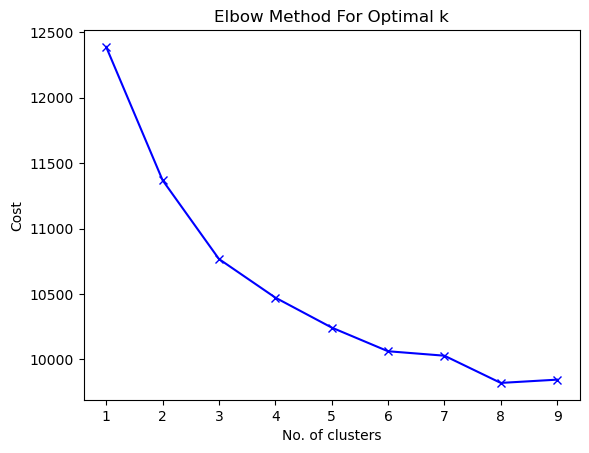

In [50]:
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters = num_clusters, init = "random", n_init = 5, verbose = 1)
    kmode.fit_predict(nolaBus5)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [114]:
kmode = KModes(n_clusters = 6, init = "random", n_init = 5, verbose = 1)
clusters = kmode.fit_predict(nolaBus5)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 805, cost: 11216.0
Run 1, iteration: 2/100, moves: 54, cost: 11216.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1110, cost: 10799.0
Run 2, iteration: 2/100, moves: 268, cost: 10751.0
Run 2, iteration: 3/100, moves: 9, cost: 10751.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 978, cost: 10538.0
Run 3, iteration: 2/100, moves: 0, cost: 10538.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 295, cost: 12062.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 603, cost: 10477.0
Best run was number 5


array([2, 4, 0, ..., 2, 5, 5], dtype=uint16)

In [115]:
nolaBus5['kmodes_cluster'] = clusters

/var/folders/w3/x0690xnx12bcnwv0x7n6s4q00000gn/T/ipykernel_2573/942209277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nolaBus5['kmodes_cluster'] = clusters


In [116]:
nolaBus5['kmodes_cluster'].value_counts()

4    681
5    600
2    335
3    288
0    187
1    171
Name: kmodes_cluster, dtype: int64

In [117]:
# Get dataframe
nolaBusName = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/nolaRestaurants.csv')
nolaBus6 = pd.merge(nolaBus5['kmodes_cluster'], nolaBus, how = 'inner', left_index = True, right_index = True)
nolaBus6 = pd.merge(nolaBusName['name'], nolaBus6, how = 'inner', left_index = True, right_index = True)

Based on a quick scan of the above, it looks like at least one of the clusters is primarily differentiated by having the 'Nightlife' tag. I want to look into this further:

In [118]:
def get_top_categories(data, cluster_column, categories_column, top_n=5):
    top_categories = pd.DataFrame(columns = ['Cluster', 'Category', 'Percentage'])
    for i in data[cluster_column].unique():
        categories = []
        for category in data[data[cluster_column] == i][categories_column]:
            categories.extend(category.split(', '))
        categories = pd.DataFrame({'Category': categories})
        category_counts = categories.groupby('Category').size().reset_index(name='Count')
        total_items = len(data[data[cluster_column] == i])
        category_counts['Percentage'] = category_counts['Count'] / total_items * 100
        top_categories_i = category_counts.sort_values('Count', ascending=False).head(top_n)
        top_categories_i['Cluster'] = i
        # top_categories = top_categories.append(top_categories_i)
        top_categories = pd.concat([top_categories, top_categories_i], axis = 0)
    return top_categories

In [122]:
top_categories = get_top_categories(nolaBus6, 'kmodes_cluster', 'categories', 5)

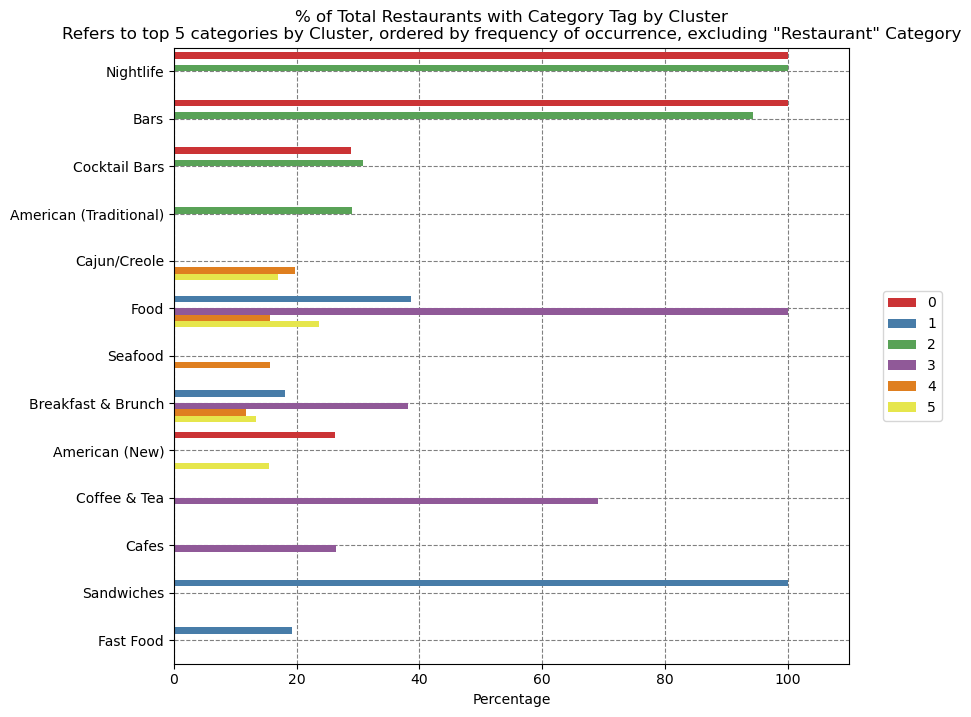

In [124]:
plt.figure(figsize = (10, 8))
plt.title('% of Total Restaurants with Category Tag by Cluster\nRefers to top 5 categories by Cluster, ordered by frequency of occurrence, excluding "Restaurant" Category')
ax = sns.barplot(data = top_categories[top_categories['Category'] != 'Restaurants'], x = 'Percentage', y = 'Category', 
            hue = 'Cluster', palette = 'Set1', width = 0.8)
ax.legend(bbox_to_anchor = (1.05, 0.5), loc = 'center left', borderaxespad = 0)
plt.subplots_adjust(right = 0.8)
ax.set(ylabel=None)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
plt.xlim(0, 110)
plt.show()

## Takeaways:

1. The above is slightly surprising as I was honestly expecting to get more clusters. My guess is that the reason why we don't have more clusters has to do with the sparsity of the categories overall, where many of the categories are associated with a small number of restaurants. My understanding of kmodes is that it works by basically looking at the most common values within a cluster. In that case, it makes sense why category sparsity would result in fewer overall categories, but still, I'm overall a bit surprised.
2. Despite the small number of clusters, there are some clear patterns that emerge out of the kmodes clustering:
    - What we inititally suspected was correct, in that there's a fairly large divide between traditional restaurants and bars/nightlife venues that also serve food as indicated by Cluster 2. It looks like at least some of these venues refer to brunch spots.
    - There's also a clear delineation for what appears to be bakery/cafe type places, as indicated by Cluster 1
    - Cluster 0 appears to contain Fast Food restaurants such as Domino's and Mcdonald's as well as many Creole/Cajun restaurants
    - Cluster 3 is the least obvious to me, but it's also the smallest cluster by a long shot and appears to contain cafe type restaurants similar to Cluster 1. My guess is that the differentiating factor here is zip code.

### Cleaning Business Categories:

- Remove unrelated categories (ex: 'Wholesalers', 'Barbers', etc.)
- Combine similar categories (ex: 'Gelato', 'Ice Cream & Frozen Yogurt')

In [58]:
# create list of unrelated categories based off work Zoya did
randomCategories = ['Apartments',
                 'Arcades',
                 'Art Galleries',
                 'Boating',
                 'Bowling',
                 'Community Service/Non-Profit',
                 'Convenience Stores',
                 'Cooking Schools',
                 'Country Clubs',
                 'Dance Clubs',
                 'Eatertainment',
                 'Education',
                 'Fitness & Instruction',
                 'Fruits & Veggies',
                 'Gift Shops',
                 'Gyms',
                 'Home Services',
                 'Landmarks & Historical Buildings',
                 'Local Services',
                 'Mass Media',
                 'Music Venues',
                 'Musicians',
                 'Party & Event Planning',
                 'Photographers',
                 'Pool Halls',
                 'Real Estate',
                 'Resorts',
                 'Social Clubs',
                 'Souvenir Shops',
                 'Specialty Schools',
                 'Tobacco Shops',
                 'Wholesale Stores',
                 'Adult Entertainment',
                 'Flowers & Gifts',
                 'Personal Chefs',
                 'Public Services & Government',
                 'Active Life',
                 'Arts & Entertainment',
                 'Boat Charters',
                 'Event Planning & Services',
                 'Grocery',
                 'Hotels',
                 'Jazz & Blues',
                 'Local Flavor',
                 'Lounges',
                 'Pubs',
                 'Restaurants',
                 'Shopping',
                 'Tours',
                 'Venues & Event Spaces',
                 'Bar Crawl',
                 'Karaoke',
                 'Caterers',
                 'Food',
                 'Teppanyaki',
                 'Bed & Breakfast',
                 'Furniture Stores',
                 'Heating & Air Conditioning/HVAC',
                 'Kitchen & Bath',
                 'Pretzels', # tagged as other things 
                 'Religious Organizations',
                 'Restaurant Supplies',
                 'Salvadoran', # tagged as other things 
                 'Travel Agents',
                 'Travel Services',
                 'Wholesalers',
                 'Yelp Events',
                 'Appliances',
                 'Cabaret',
                 'Cultural Center',
                 'Herbs & Spices',
                 'Nicaraguan', # tagged as other things 
                 'Pop-up Shops',
                 'Barbers',
                 'Discount Store',
                 'Drugstores',
                 'Health & Medical',
                 'Nutritionists',
                 'Smokehouse', # tagged as other things 
                 'Aquariums',
                 'Bike Repair/Maintenance',
                 'Bikes',
                 'Day Spas',
                 'Fashion',
                 'Hair Salons',
                 'Performing Arts',
                 'Skin Care',
                 'Sports Wear',
                 'Organic Stores',
                 'Parks',
                 'Professional Services',
                 'Sporting Goods',
                 'Golf',
                 'Shared Office Spaces',
                 'Beauty & Spas',
                 'Cafeteria', # tagged as other things 
                 'Automotive',
                 'Swimming Pools',
                 'Gas Stations',
                 'Wedding Planning',
                 'Nurseries & Gardening',
                 'Party Supplies',
                 'Health Markets',
                 'Home & Garden',
                 'Bed & Breakfast',
                 'Automotive', 'British', 'Malaysian', 'Egyptian', 'Polish', 'Russian', 'Ukrainian','Burmese','Arabic', 'Shanghainese', 
                 'Argentine', 'Laotian','Acai Bowls','Arabic', 'Shanghainese','Haitian','Candy Stores','Szechuan','Venezuelan','Basque','Pasta Shops',
                 'Empanadas', 'Fondue', 'Argentine', 'Pan Asian','Kebab','Lebanese','Pakistani','Colombian','Halal','Falafel']

In [61]:
# create empty list of row index where category is in empty categories
indexRemove = []

# iterate through categories column and identify rows that should be removed
# for index, category in enumerate(nola2['categories']):
#     if category in randomCategories:
#        indexRemove.append(index)
        
# remove rows where category is in empty categories
# nola2 = nola2.drop(indexRemove)

# reset index
# nola2 = nola2.reset_index(drop = True)

In [ ]:
# create list of categories to combine
categories_to_combine = [['Brewpubs', 'Distilleries', 'Wine & Spirits', 'Wine Tasting Room', 'Bars', 'Beer', 'Breweries', 'Wineries'], 
                         ['Macarons', 'Patisserie/Cake Shop', 'Bakeries', 'Cupcakes', 'Custom Cakes'], ['Auction Houses', 'Farmers Market'], ['Delicatessen', 'Delis'],
                         ['Coffee & Tea', 'Coffee Roasteries', 'Tea Rooms', 'Cafes'], ['Creperies', 'Waffles'], 
                         ['Ice Cream & Frozen Yogurt',  'Shaved Ice',  'Shaved Snow', 'Gelato'], 
                         ['Middle Eastern', 'Moroccan'],
                         ['Meat Shops','Butcher'], ['Alcohol', 'Nightlife'], 
                         ['Hawaiian','Poke'],
                         ['Brasseries','German'],
                         ['Middle Eastern', 'Mediterranean']]

# create list of combined categories to map to
titles = ['Alcohol', 'Bakeries', 'Markets', 'Delis', 'Coffee_and_Tea', 'Pancakes_and_Waffles', 'Frozen_Desserts', 'Middle Eastern', 'Meat Shops', 'Alcohol/Nightlife', 'Hawiian/Poke', 'German' , 'Middle_East/Mediteranean']

# create empty dictionary of category combinations
catCombine = {}

# create category mappings
for i, cat in enumerate(categories_to_combine):
    for val in cat:
        catCombine[val] = titles[i]

# rename categories where needed
nola2['categories'] = nola2['categories'].rename(catCombine)

In [ ]:
# view cleaned data
nola2.head(2)